# INVENTORY MONITORING AT DISTRIBUTION CENTERS

The focus of this work is to use a computer vision model to count the number of items in a bin at the amazon distribution center.
This notebook contains code for end to end training of a model on the amazon bin image dataset in the cloud using aws. It contains code for downloading the data, and uploading data to s3 bucket. We perform hyperparameter tuning to find the best hyperparameters. Both single instance and multi-instance training are performed. Model is also deployed to endpoint to make inference.

The actual training scripts for training are stored in external files. We use transfer learning method in these files making use of a pre-trained ResNet50 model. All training is done using PyTorch.


### Install and Import

In [2]:
%%capture
!pip install smdebug torch torchvision tqdm torchmetrics

In [3]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

import os
import json
import boto3
from tqdm import tqdm
import random
import torchmetrics

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

### data prep modification

I have added `random_split` and `save_json` files that split the `file_list.json` into train and test files and save them respectively whilst maintaining the same structure as the `file_list.json`. I also modified the given function `download_and_arrange` to accept input to create separate folders for train and test

In [4]:
def random_split(filename: str):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    # load json
    res = json.loads(lines[0])
    
    # split into train, test
    l = [(k, item) for k,v in res.items() for item in v]
    
    random.shuffle(l)
    train_size = int(len(l) * 0.8)
    train, test = l[:train_size], l[train_size:]
    
    return train, test
    

In [8]:
# save file to json files but maintain structure of original file_list.json

def save_json(file):
    file_json = {
        "1": [],
        "2": [],
        "3": [],
        "4": [],
        "5": []
    }
    
    if file == train_list:
        filename = 'train_list.json'
    else:
        filename = 'test_list.json'
        
    for key, item in file:
        file_json[key].append(item)
        
    # write to file
    with open(filename, "w") as fp:
        json.dump(file_json, fp)

In [6]:
train_list, test_list = random_split("file_list.json")

In [9]:
save_json(train_list)
save_json(test_list)

In [20]:
# import shutil
# import os
  
# # location
# location = "train_data"
  
# # directory
# dir = "5"
  
# # path
# path = os.path.join(location, dir)
  
# # removing directory
# shutil.rmtree(path)

In [21]:
def download_and_arrange_data(filename: str):
    s3_client = boto3.client('s3')

    with open(filename, 'r') as f:
        d=json.load(f)
        
    if "train" in filename:
        file = 'train_data'
    else:
        file = 'test_data'

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(file, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

# download_and_arrange_data()

In [22]:
download_and_arrange_data('train_list.json')

100%|██████████| 999/999 [01:12<00:00, 13.87it/s]


100%|██████████| 1824/1824 [02:18<00:00, 13.14it/s]


100%|██████████| 2156/2156 [02:45<00:00, 13.00it/s]


100%|██████████| 1894/1894 [02:25<00:00, 13.04it/s]


100%|██████████| 1479/1479 [01:52<00:00, 13.14it/s]


In [23]:
download_and_arrange_data('test_list.json')

100%|██████████| 229/229 [00:18<00:00, 12.16it/s]


100%|██████████| 475/475 [00:36<00:00, 13.18it/s]


100%|██████████| 510/510 [00:40<00:00, 12.64it/s]


100%|██████████| 479/479 [00:35<00:00, 13.55it/s]


100%|██████████| 396/396 [00:30<00:00, 13.09it/s]


In [49]:
# data distribution


## Dataset

The original [Amazon Bin Image Dataset](https://registry.opendata.aws/amazon-bin-imagery/) [2] contains 500,000 images (jpg format) from bins (containing one or more objects) of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. For each image there is a metadata file (json format) containing information about the image like the number of objects, it's dimension and the type of object. For this task, only a subset of the dataset used to classify the number of objects in each bin in order to avoid excess cost and the item count from the metadata is used as the label to train the model.

Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers.


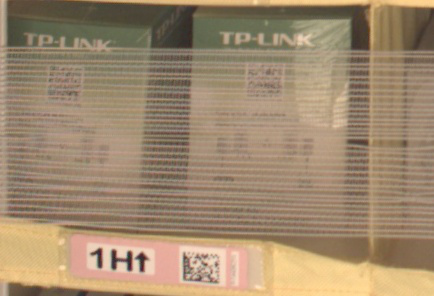

In [3]:
# sample image
import requests
from PIL import Image
import io

request_dict = {"url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/559.jpg"}
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

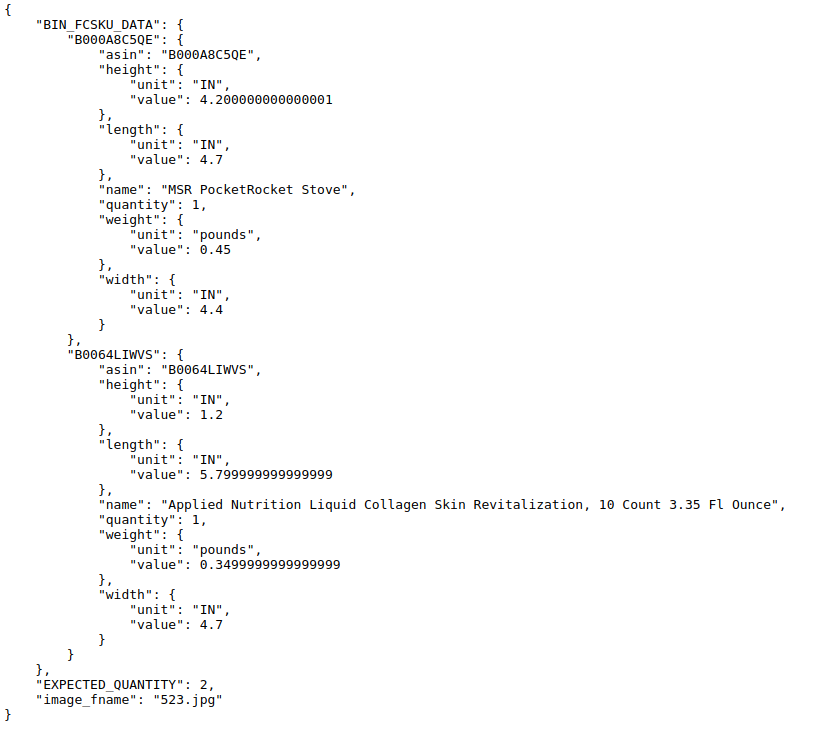

In [51]:
# sample metadata
Image.open(r"metadata.png")

### Visualization

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# read json files and convert to dictionary with total count of items as values
with open('train_list.json') as f:
    train_json = json.load(f)

train_plot = {
    "col_names": [],
    "total_items":[]
}

for key, value in train_json.items():
    train_plot["col_names"].append(key)
    train_plot["total_items"].append(len(value))

train_plot

{'col_names': ['1', '2', '3', '4', '5'],
 'total_items': [999, 1824, 2156, 1894, 1479]}

In [6]:
# create dataframe from dictionary

df = pd.DataFrame(data=train_plot)
df.head()

,col_names,total_items
0,1,999
1,2,1824
2,3,2156
3,4,1894
4,5,1479


<AxesSubplot:xlabel='col_names'>

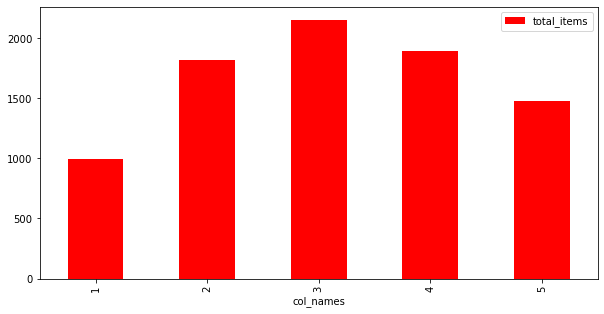

In [9]:
# plot bar graph 

df.plot(figsize=(10, 5),kind ='bar', x="col_names", y="total_items", color='red')

In [10]:
# visualize test data

# read json files and convert to dictionary with total count of items as values
with open('test_list.json') as f:
    test_json = json.load(f)

test_plot = {
    "col_names": [],
    "total_items":[]
}

for key, value in test_json.items():
    test_plot["col_names"].append(key)
    test_plot["total_items"].append(len(value))

test_plot

{'col_names': ['1', '2', '3', '4', '5'],
 'total_items': [229, 475, 510, 479, 396]}

In [11]:
# create dataframe from dictionary

df = pd.DataFrame(data=test_plot)
df.head()

,col_names,total_items
0,1,229
1,2,475
2,3,510
3,4,479
4,5,396


<AxesSubplot:xlabel='col_names'>

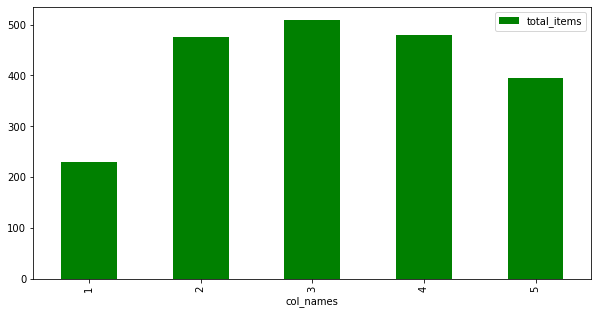

In [12]:
# plot bar graph 

df.plot(figsize=(10, 5),kind ='bar', x="col_names", y="total_items", color='green')

### create s3 bucket

In [4]:
# Create an s3 bucket

import logging
from botocore.exceptions import ClientError


def create_bucket(bucket_name, region=None):
    """ Create an S3 bucket in a specified region
    
    If a region is not specified, the bucket is created in the S3 default region us-east-1
    
    :param bucket_name: Bucket to create
    :param region: String refion to create bucket in, eg. 'us-west-2'
    :return: True if bucket created, else False
    
    """
    
    #  create bucket
    try:
        if region is None:
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name, CreateBucketConfiguration=location)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [4]:
create_bucket('inventory-bin')

True

In [5]:
# List existing buckets
# retrieve the list of existing bucket
s3 = boto3.client('s3')
response = s3.list_buckets()

# output the bucket names
print(f"Existing buckets: ")
for bucket in response['Buckets']:
    print(f" {bucket['Name']}")


Existing buckets: 
 inventory-bin


In [4]:
# sagemaker_session = sagemaker.Session(default_bucket='inventory-bin')
# bucket = sagemaker_session.default_bucket()
# print(bucket)

# !aws s3 rb s3://sagemaker-us-east-1-641975562295 --force

### Upload data to AWS S3 bucket

In [6]:
%%capture
#TODO: Upload the data to AWS S3

!aws s3 cp train_data s3://inventory-bin/train_data/ --recursive

In [8]:
%%capture
!aws s3 cp test_data s3://inventory-bin/test_data/ --recursive

upload: test_data/1/00035.jpg to s3://inventory-bin/test_data/1/00035.jpg            
upload: test_data/1/00024.jpg to s3://inventory-bin/test_data/1/00024.jpg             
upload: test_data/1/00237.jpg to s3://inventory-bin/test_data/1/00237.jpg              
upload: test_data/1/00088.jpg to s3://inventory-bin/test_data/1/00088.jpg              
upload: test_data/1/00981.jpg to s3://inventory-bin/test_data/1/00981.jpg            
upload: test_data/1/00672.jpg to s3://inventory-bin/test_data/1/00672.jpg            
upload: test_data/1/00343.jpg to s3://inventory-bin/test_data/1/00343.jpg             
upload: test_data/1/00586.jpg to s3://inventory-bin/test_data/1/00586.jpg             
upload: test_data/1/01494.jpg to s3://inventory-bin/test_data/1/01494.jpg             
upload: test_data/1/00580.jpg to s3://inventory-bin/test_data/1/00580.jpg             
upload: test_data/1/00923.jpg to s3://inventory-bin/test_data/1/00923.jpg             
upload: test_data/1/00723.jpg to s3://invent

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [5]:
#TODO: Create your hyperparameter search space
# from sagemaker.tuner import IntegerParameter

hyperparameter_ranges = {
    "lr": ContinuousParameter(1e-5, 1e-1),
    "batch_size": CategoricalParameter([32, 64]),
    "epochs": CategoricalParameter([10, 15, 30])
}

role = sagemaker.get_execution_role()

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [15]:
# sagemaker tuner

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "inventory_hpo",
    role = role,
    framework_version = "1.4.0",
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge", #"ml.m5.xlarge",
    py_version = "py3",
#     sagemaker_session = sagemaker_session
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 2,
    max_parallel_jobs = 2,
    objective_type = objective_type
#     early_stopping_type = "Auto"
)

In [16]:
# TODO: Fit your tuner
os.environ['SM_CHANNEL_TRAINING'] = 's3://inventory-bin/train_data/'
os.environ['SM_CHANNEL_TESTING'] = 's3://inventory-bin/test_data/'
os.environ['SM_MODEL_DIR'] = 's3://inventory-bin/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://inventory-bin/output/'


### Fit the trainer

In [ ]:
tuner.fit({"training": 's3://inventory-bin/train_data/', 'testing': 's3://inventory-bin/test_data/'}, wait=True, logs=True)

.....................................................................................................................................................................................................................................................................................................................................................................................................................................!


### Describe the tuning results

In [29]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-training-220112-0000'

In [19]:
tuner_job_name = tuner.describe()['HyperParameterTuningJobName']

In [20]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
    hyperparameter_tuning_job_name = tuner_job_name
)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""64""","""15""",0.000016,pytorch-training-220112-0000-001-cf14b9c2,Completed,1.5090,2022-01-12 00:04:27+00:00,2022-01-12 00:19:32+00:00,905.0
0,"""32""","""30""",0.000367,pytorch-training-220112-0000-002-f4157e36,Completed,1.4351,2022-01-12 00:03:55+00:00,2022-01-12 00:32:40+00:00,1725.0


In [21]:
best_estimator = tuner.best_estimator()


2022-01-12 00:32:40 Starting - Preparing the instances for training
2022-01-12 00:32:40 Downloading - Downloading input data
2022-01-12 00:32:40 Training - Training image download completed. Training in progress.
2022-01-12 00:32:40 Uploading - Uploading generated training model
2022-01-12 00:32:40 Completed - Training job completed


In [22]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '"30"',
 'lr': '0.0003667366574731279',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"inventory_hpo-2022-01-12-00-00-42-643"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-641975562295/inventory_hpo-2022-01-12-00-00-42-643/source/sourcedir.tar.gz"'}

In [40]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                  "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": int(best_estimator.hyperparameters()['epochs'].replace('"', ''))
                  }

hyperparameters

{'batch_size': 32, 'lr': '0.0003667366574731279', 'epochs': 30}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [8]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [9]:
hook_config = DebuggerHookConfig(
    hook_parameters = {
        "train.save_interval": "5",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=100, framework_profile_params=FrameworkProfile(num_steps=5)
)

In [43]:
estimator = PyTorch(
    entry_point = 'train.py',
    base_job_name = 'Inventory-training',
    role = role,
    instance_count = 1,
    instance_type = 'ml.g4dn.xlarge', #'ml.m5.xlarge',
    framework_version = '1.4.0',
    py_version = 'py3',
    hyperparameters = hyperparameters,
    rules = rules,
    profiler_config = profiler_config,
)

In [ ]:
estimator.fit({"training": 's3://inventory-bin/train_data/', 'testing': 's3://inventory-bin/test_data/'}, wait = True, logs = True)

2022-01-12 01:30:48 Starting - Starting the training job...
2022-01-12 01:31:12 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-12 01:32:12 Starting - Preparing the instances for training.........
2022-01-12 01:33:41 Downloading - Downloading input data.........
2022-01-12 01:35:14 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-12 01:35:31,775 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-12 01:35:31,795 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-12 01:35:33,210 sagemaker_pytorch_container.training INFO     Invoking user training script.

2022-01-12 01:35:42 Training - Training image download completed. Training in progress.20

In [45]:
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

Training jobname: Inventory-training-2022-01-12-01-30-48-139
Region: us-east-1
[2022-01-12 02:11:48.772 ip-172-16-116-69:9743 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [46]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-01-12 02:11:52.628 ip-172-16-116-69:9743 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-12-01-30-48-139/debug-output


In [47]:
trial.tensor_names()

[2022-01-12 02:11:56.199 ip-172-16-116-69:9743 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-12 02:11:57.223 ip-172-16-116-69:9743 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [48]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

16

In [49]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

[2022-01-12 02:12:11.172 ip-172-16-116-69:9743 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-12-01-30-48-139/debug-output
[2022-01-12 02:12:12.235 ip-172-16-116-69:9743 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-12 02:12:13.266 ip-172-16-116-69:9743 INFO trial.py:210] Loaded all steps


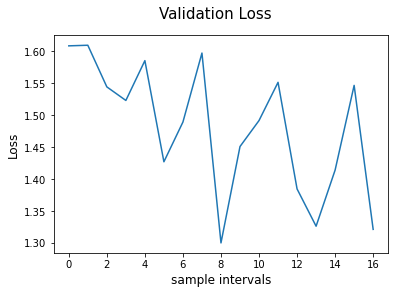

In [50]:
import matplotlib.pyplot as plt

from smdebug.trials import create_trial
from smdebug import modes
import numpy as np

# get tensors from s3
s3_out = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_out)

# get all tensor names
trial.tensor_names()
# GET VALUES of val acc
values = trial.tensor("CrossEntropyLoss_output_0").values(modes.GLOBAL)

# convert values to numpy
val_eval = np.array(list(values.items()))

# plot
fig = plt.figure()
plt.plot(val_eval[:, 1])
fig.suptitle("Validation Loss", fontsize=15)
plt.xlabel("sample intervals", fontsize=12)
plt.ylabel("Loss", fontsize=12)
fig.savefig('temp_loss.jpg')

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


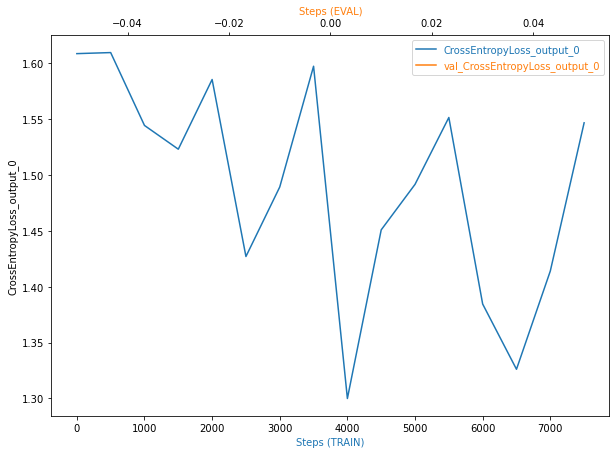

In [52]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [53]:
# Display profileer output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

# copy to local env
! aws s3 ls {rule_output_path} --recursive

2022-01-12 02:03:15     393727 Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-12 02:03:14     246473 Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-12 02:03:10        570 Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-12 02:03:10      43120 Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-12 02:03:10        126 Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-12 02:03:10        331 Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-12 02:03:10      18748 Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-outp

In [54]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-12-01-30-48-139/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker

In [55]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [62]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

There is no typical debugging error from the estimator output and cloudwatch logs. Loss decreases steadily and also accuracy increases. However,  the trial output tensor registered is only 1 thus the plot shows nothing. Also because the dataset used is very small, model did not perform really well.
Also, if the loss was increasing, I would try using different learning rates. if model overfits, I will also try data augmentation as well as use more data but because of cost, I used the small dataset. Also there was some Poor Weight Initialization issues and Vanishing Gradient issues encountered.

In [57]:
# check system utilization
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-641975562295/', 'ProfilingIntervalInMilliseconds': 100, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 5, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 5, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }'}}
s3 path:s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-12-01-30-48-139/profiler-output


Profiler data from system is available


In [58]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-01-12 02:15:23.047 ip-172-16-116-69:9743 INFO metrics_reader_base.py:134] Getting 30 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


0.6.2


### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [84]:
# get model location
model_location = estimator.model_data
print(f"model location: {model_location}")

model location: s3://sagemaker-us-east-1-641975562295/Inventory-training-2022-01-09-10-48-07-648/output/model.tar.gz


In [85]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [86]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [87]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [88]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


------!

In [97]:
import requests
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/559.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

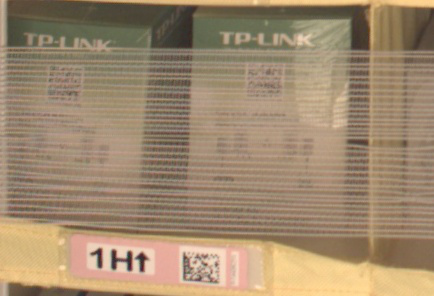

In [98]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [91]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [95]:
response[0]

[-0.9853789210319519,
 -0.08775883167982101,
 0.31788918375968933,
 0.12430925667285919,
 -0.05316224694252014]

In [96]:
import numpy as np
np.argmax(response, 1)

array([2])

In [123]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

Here model is train on 3 instances.

In [65]:
# TODO: Train your model on Multiple Instances

multi_estimator = PyTorch(
    entry_point='train.py',
    base_job_name='inventory-bin-multi',
    role=role,
    instance_count=2,
    instance_type= 'ml.g4dn.xlarge', #'ml.c4.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [66]:
multi_estimator.fit({"training": 's3://inventory-bin/train_data/', 'testing': 's3://inventory-bin/test_data/'}, wait=True, logs=True)

2022-01-12 03:04:44 Starting - Starting the training job...
2022-01-12 03:05:12 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-12 03:06:13 Starting - Preparing the instances for training.........
2022-01-12 03:07:33 Downloading - Downloading input data.........
2022-01-12 03:09:14 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-12 03:09:27,771 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-12 03:09:27,792 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2022-01-12 03:09:34 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in th